# Drafting & Work

## Preparation

In [172]:
### IMPORTED PACKAGES ###

library(ggplot2) # data visualization
library(tidyverse) # dataset manipulation (includes dplyr)

# PCA calculation and visualization
library(factoextra)
library(FactoMineR)

library(car) # Levene test
library(FSA) # Dunn test

library(vegan) # PERMANOVA

Loading required package: permute



In [78]:
### MAIN DATAFRAMES ###

# load dataset
sharks = read.table("datasets/shark_immunity.txt", header = TRUE, sep = "\t")

# change the order the physiological conditions are displayed 
sharks$physiological_condition <- factor(
  sharks$physiological_condition,
  levels = c("Healthy", "Stressed", "Injured", "Infected", "Recovering")
)
# reduces name to just the gene
names(sharks) <- sub("_expression", "", names(sharks))
# add identification based on immune cell type and physiological condition
sharks$group = paste(sharks$physiological_condition, sharks$immune_cell_type, sep="_")

# dataframe with gene expression split into 2 variables
shark_genes = sharks %>% 
    pivot_longer(
        cols = starts_with("Gene_"),
        names_to = "gene",
        values_to = "expression"
    )
    
# dataframe where all numerical variables are split into 2 variables
sharks_super_long = sharks %>%
    select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F, regeneration_capacity, age_years, immune_receptor_diversity, response_to_infection, inflammation_level, weight_kg, habitat_location,resilience_score, reproduction_rate, group) %>% 
  
    pivot_longer(
        cols = -c("physiological_condition","immune_cell_type","Gene_A","Gene_B","Gene_C","Gene_D","Gene_E","Gene_F","habitat_location", "group"), 
        names_to = "variable", 
        values_to = "value") %>%
    
        select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F,habitat_location,group,variable,value) %>% 
    
        pivot_longer(
            cols = -c("physiological_condition","immune_cell_type","habitat_location","group","variable","value"),
            names_to = "gene",
            values_to = "expression")

In [79]:
### DATA SELECTION FUNCTIONS ###
condition_data = function(data, condition) { data[data$physiological_condition==condition, ] }

cell_data = function(data, cell_type) { data[data$immune_cell_type==cell_type, ] }

## 1. Immune Response Profiles of Different Immune Cell Types in the Infected Condition

Do the immune reponse profiles differ from one immune cell type to another in the infected condition? If so, how so?

### Introduction

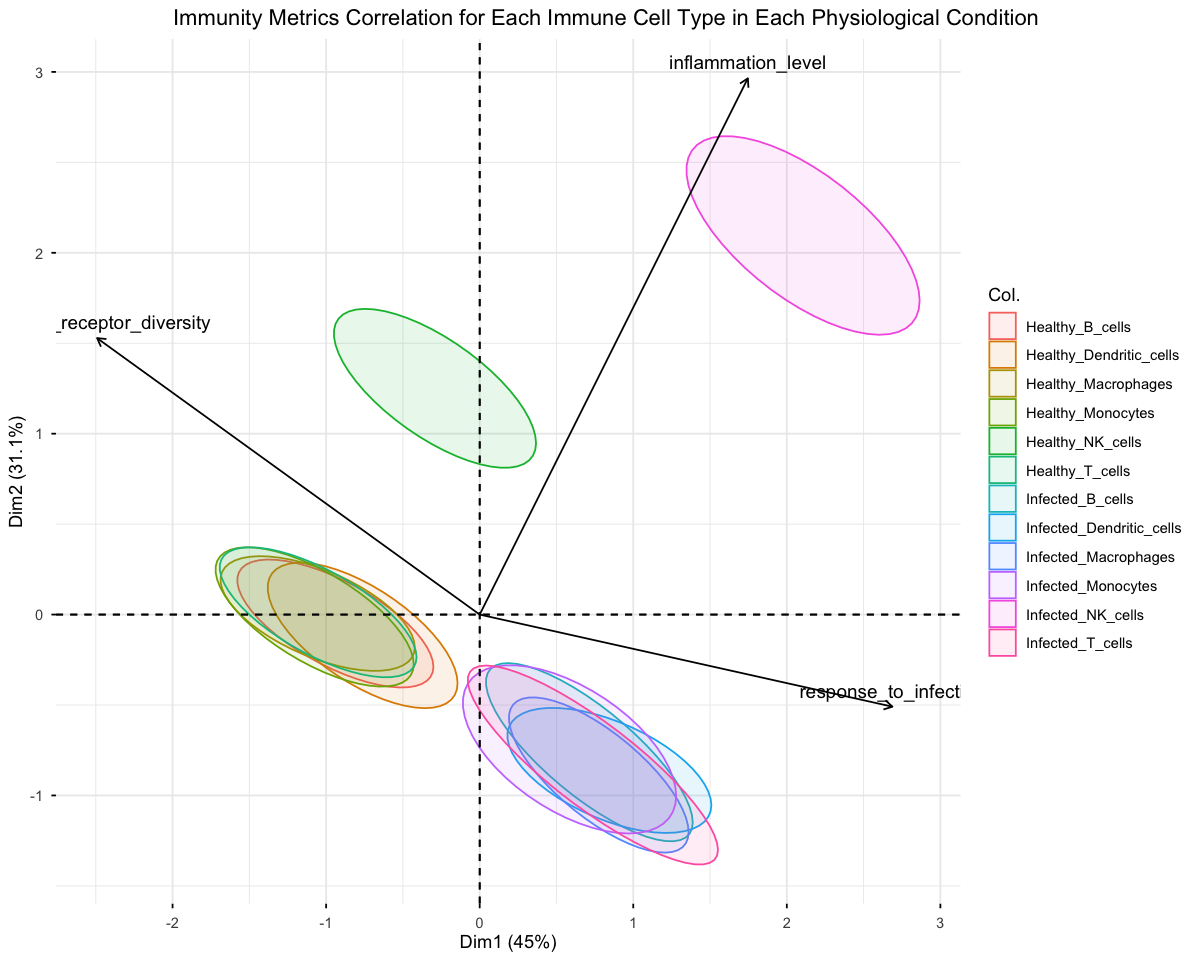

In [80]:
# healthy and infected population
healthy_infected = sharks %>% filter(physiological_condition %in% c("Healthy", "Infected"))

# PCA on response to infection, inflammation level, and immune receptor diversity metrics
h_inf_pca <- PCA(healthy_infected[c("response_to_infection","inflammation_level","immune_receptor_diversity")], scale.unit=TRUE, graph=FALSE)

# customize graph size
options(repr.plot.width=10, repr.plot.height=8)

# MDS cloud plot with correlation circle
fviz_pca_biplot(h_inf_pca, geom.ind="None", col.ind=healthy_infected$group, col.var="black", addEllipses=TRUE, ellipse.level=0.5, title="Immunity Metrics Correlation for Each Immune Cell Type in Each Physiological Condition") +
    theme(plot.title=element_text(hjust=3))


To properly determine the immune response profile of different immune cells types in the infected condition, I need to compare it to that of the healthy condition.

It seems that the NK cells are distiguished from other immune cell types by their inflammation level. 

It also seems that the difference between the healthy and infected conditions is that the healthy cells are more correlated with immune receptor diversity while the infected cells are more correlated with response to infection, which is also true for NK cells.

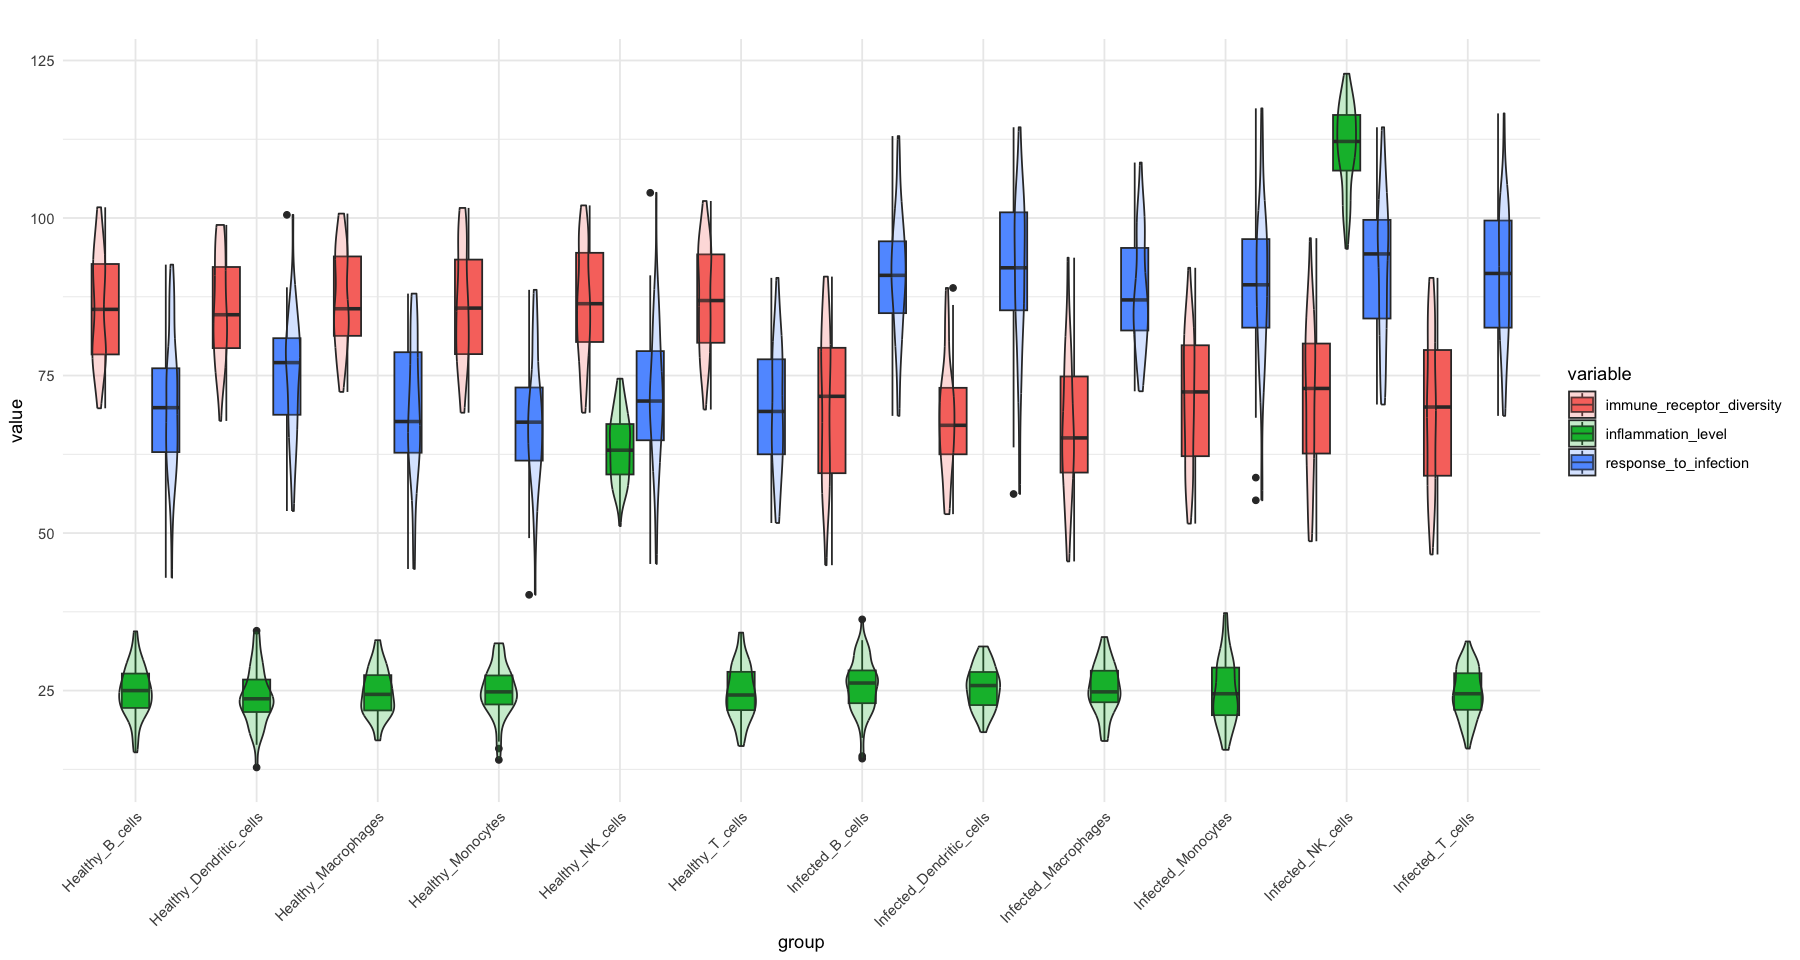

In [81]:
# long dataframe for healthy and infected populations on immune response metrics
h_inf_immune = healthy_infected[c("physiological_condition","immune_cell_type","immune_receptor_diversity","response_to_infection","inflammation_level","group")] %>%
    pivot_longer(
        cols = -c("physiological_condition","immune_cell_type","group"),
        names_to = "variable",
        values_to = "value"
    )

# customize graph size
options(repr.plot.width=15, repr.plot.height=8)

ggplot(h_inf_immune, aes(x=group, y=value, fill=variable)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal() +
    theme(
        axis.text.x=element_text(angle=45, hjust=1),
        plot.title=element_text(hjust=8)
    ) +
    ggtitle("Immune Response Levels Across Immune Cell Types in Healthy and Infected Conditions")

### Inflammation Level Profile

It seems that all immune cell types except NK cells had very similar inflammation levels, regardless of whether they were in healthy or infected conditions.

It also seems as though the infection response and immune receptor diversity profiles reverse between the healthy and infected conditions.

In [82]:
# select inflammation levels for healthy and infected populations
h_inf_inflam = h_inf_immune[h_inf_immune$variable=="inflammation_level", ]

# test the normality of the inflammation level data for healthy and infected populations
h_inf_inflam %>%
    group_by(group) %>%
    summarise(p_value = shapiro.test(value)$p.value)

group,p_value
<chr>,<dbl>
Healthy_B_cells,0.90525866
Healthy_Dendritic_cells,0.53154464
Healthy_Macrophages,0.65941410
Healthy_Monocytes,0.41745223
Healthy_NK_cells,0.38072358
Healthy_T_cells,0.46554625
Infected_B_cells,0.52597683
Infected_Dendritic_cells,0.86273029
Infected_Macrophages,0.97692907


The Shapiro-Wilks test confirms that the inflammation levels are normally distributed for each immune cell type in either healthy or infected conditions.

#### Without Levene Test, With Anova, With Tukey HSD 


In [83]:
# anova on the inflammation levels
h_inf_inflam_anova = aov(data=healthy_infected, inflammation_level ~ group)
summary(h_inf_inflam_anova)

             Df Sum Sq Mean Sq F value Pr(>F)    
group        11 492138   44740    2142 <2e-16 ***
Residuals   708  14789      21                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

ANOVA confirms that a statistical difference exists between the groups (physiological conditio-immune cell type).

In [84]:
# Tukey HSD post hoc test on the inflammation levels
h_inf_inflam_tukey = TukeyHSD(h_inf_inflam_anova)$group
head(h_inf_inflam_tukey)

,diff,lwr,upr,p adj
Healthy_Dendritic_cells-Healthy_B_cells,-0.79869478,-3.516269,1.918880,0.9983427
Healthy_Macrophages-Healthy_B_cells,-0.21343837,-3.122910,2.696033,1.0000000
Healthy_Monocytes-Healthy_B_cells,0.04472627,-2.533334,2.622786,1.0000000
Healthy_NK_cells-Healthy_B_cells,38.84477369,36.448699,41.240849,0.0000000
Healthy_T_cells-Healthy_B_cells,-0.15664052,-2.462647,2.149366,1.0000000
Infected_B_cells-Healthy_B_cells,0.83271548,-1.649507,3.314938,0.9946525


The Tukey HSD post hoc test identifies between which pairs a statistical difference exists. If the p adj value is less than 0.05, then the concerned pair has a statistical difference.

In [85]:
# get the list of pairs that have a p adj value less than 0.05
inflam_diff_res = h_inf_inflam_tukey[h_inf_inflam_tukey[,"p adj"] < 0.05, "p adj"]

# get pair names (no need for the p adj value)
inflam_pair_lst = as.list(names(inflam_diff_res))

In [86]:
# check in NK cells actually are involved in every pair
not_NK = logical()
has_NK = logical()
for (p in inflam_pair_lst) {
    ps = str_split_fixed(p, "-", 2)
    a = str_split_fixed(ps[1], "_", 2)
    b = str_split_fixed(ps[2], "_", 2)
    if (a[2] != "NK_cells" && b[2] != "NK_cells") { not_NK = c(not_NK, TRUE) }
    if (a[2] == "NK_cells" || b[2] == "NK_cells") { has_NK = c(has_NK, TRUE) }

    if (a[2] == "NK_cells" && b[2] == "NK_cells") { print("NK") }
}

sprintf("%d pairs where p adj < 0.05", length(inflam_pair_lst))
sprintf("%d pairs neither cell type is not an NK cell.", length(not_NK))
sprintf("%d pairs where at least one cell type is an NK cell.", length(has_NK))
if (length(has_NK) == length(inflam_pair_lst)) { sprintf("All pairs where p adj < 0.05 have at least one cell type that is an NK cell.") 
} else { sprintf("Not all pairs were p adj < 0.05 have a cell type that is an NK cell.") }

[1] "NK"


[1] "21 pairs where p adj < 0.05"

[1] "0 pairs neither cell type is not an NK cell."

[1] "21 pairs where at least one cell type is an NK cell."

[1] "All pairs where p adj < 0.05 have at least one cell type that is an NK cell."

>I had assumed that all pairs whose p adj value were less than 0.05 would naturally have at least one cell type that was an NK cell, but this could have been careless assumption, especially with the following data manipulation.
>
>However, the code above confirms that all the pairs with a statistical difference have at least an NK cell involved.

In [87]:
# create lists of "partner" cell types, separating them based on whether they were paired with a healthy or infected NK cell
healthy_NK = list(); infected_NK = list()
h = 1; i = 1

for (p in inflam_pair_lst) {
    ps = str_split_fixed(paste(p),"-",2)
    if (ps[1] == "Healthy_NK_cells") { 
        healthy_NK[[h]] = ps[2]
        h = h + 1
    }
    if (ps[2] == "Healthy_NK_cells") { 
        healthy_NK[[h]] = ps[1]
        h = h + 1
    }
    if (ps[1] == "Infected_NK_cells") { 
        infected_NK[[i]] = ps[2]
        i = i + 1
    }
    if (ps[2] == "Infected_NK_cells") { 
        infected_NK[[i]] = ps[1]
        i = i + 1
    }
}

# create sublists of "partner" cell types, separating them further based on whether they themselves were healthy or infected
healthy_NK_h = list(); healthy_NK_i = list()
h = 1; i = 1

for (x in healthy_NK) {
    aux = str_split_fixed(x,"_",2)
    if (aux[1] == "Healthy") { 
        healthy_NK_h[h] = aux[2]
        h = h + 1
    }
    if (aux[2] == "Healthy") { 
        healthy_NK_h[h] = aux[1]
        h = h + 1
    }
    if (aux[1] == "Infected") { 
        healthy_NK_i[i] = aux[2]
        i = i + 1
    }
    if (aux[2] == "Infected") { 
        healthy_NK_i[i] = aux[1]
        i = i + 1
    }
}

infected_NK_h = list(); infected_NK_i = list()
h = 1; i = 1
for (x in infected_NK) {
    aux = str_split_fixed(x,"_",2)
    if (aux[1] == "Healthy") { 
        infected_NK_h[h] = aux[2]
        h = h + 1
    }
    if (aux[2] == "Healthy") { 
        infected_NK_h[h] = aux[1]
        h = h + 1
    }
    if (aux[1] == "Infected") { 
        infected_NK_i[i] = aux[2]
        i = i + 1
    }
    if (aux[2] == "Infected") { 
        infected_NK_i[i] = aux[1]
        i = i + 1
    }
}

# concatenate all the sublists for easy looping
partner_groups = list(healthy_NK_h, healthy_NK_i, infected_NK_h, infected_NK_i)

# get all cell types as a list
cell_types = as.list(unique(sharks$immune_cell_type))

# check that all the sublists contain all the cell types
res = logical()
for (g in partner_groups) {
    for (t in cell_types) {
        res = c(res, t %in% g)
    }
}

# create a true-false matrix 
partner_matrix = matrix(
    res,
    nrow = length(partner_groups),
    ncol = length(cell_types),
    byrow = TRUE
)
# left letter represents the NK cell; right letter represents the varying cell type
rownames(partner_matrix) = c("H - H", "H - I", "I - H", "I - I")
colnames(partner_matrix) = cell_types

partner_matrix

,Monocytes,Dendritic_cells,T_cells,NK_cells,B_cells,Macrophages
H - H,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
H - I,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
I - H,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
I - I,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE


#### With Levene Test, With Kruskal-Wallis, With Dunn

In [88]:
leveneTest(data=h_inf_inflam, value ~ group)

Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,11,4.790187,3.89404e-07
,708,NA,NA


The variances are not homogenous.

In [89]:
h_inf_inflam_kw = kruskal.test(data=healthy_infected, inflammation_level ~ group)
print(h_inf_inflam_kw)


	Kruskal-Wallis rank sum test

data:  inflammation_level by group
Kruskal-Wallis chi-squared = 342.95, df = 11, p-value < 2.2e-16



In [90]:
h_inf_inflam_dunn = (dunnTest(data=h_inf_inflam, value ~ group, method="holm")$res)

Warning message:
"group was coerced to a factor."


In [91]:
# get the list of pairs that have a p adj value less than 0.05
inflam_diff_res = h_inf_inflam_dunn[h_inf_inflam_dunn$P.adj < 0.05, ]

# get pair names (no need for the p adj value)
inflam_pair_lst = unique(inflam_diff_res$Comparison)

In [92]:
check_NK_pair = function(pair_lst) {
    not_NK = logical()
    has_NK = logical()
    for (p in pair_lst) {
        ps = str_split_fixed(p, " - ", 2)
        a = str_split_fixed(ps[1], "_", 2)
        b = str_split_fixed(ps[2], "_", 2)
        if (a[2] != "NK_cells" && b[2] != "NK_cells") { not_NK = c(not_NK, TRUE) }
        if (a[2] == "NK_cells" || b[2] == "NK_cells") { has_NK = c(has_NK, TRUE) }

        if (a[2] == "NK_cells" && b[2] == "NK_cells") { print("NK") }
    }
    print(sprintf("%d pairs where p adj < 0.05", length(pair_lst)))
    print(sprintf("%d pairs neither cell type is not an NK cell.", length(not_NK)))
    print(sprintf("%d pairs where at least one cell type is an NK cell.", length(has_NK)))
    
    if (length(has_NK) == length(pair_lst)) { 
        print(sprintf("All pairs where p adj < 0.05 have at least one cell type that is an NK cell."))
    } else { 
        print(sprintf("Not all pairs were p adj < 0.05 have a cell type that is an NK cell."))
    }
}

In [93]:
# check in NK cells actually are involved in every pair
check_NK_pair(inflam_pair_lst)

[1] "20 pairs where p adj < 0.05"
[1] "0 pairs neither cell type is not an NK cell."
[1] "20 pairs where at least one cell type is an NK cell."
[1] "All pairs where p adj < 0.05 have at least one cell type that is an NK cell."


>I had assumed that all pairs whose p adj value were less than 0.05 would naturally have at least one cell type that was an NK cell, but this could have been careless assumption, especially with the following data manipulation.
>
>However, the code above confirms that all the pairs with a statistical difference have at least an NK cell involved.

In [94]:
NK_partner_matrix = function(pair_lst) {
    # create lists of "partner" cell types, separating them based on whether they were paired with a healthy or infected NK cell
    healthy_NK = list(); infected_NK = list()
    h = 1; i = 1

    for (p in pair_lst) {
        ps = str_split_fixed(paste(p)," - ",2)
        if (ps[1] == "Healthy_NK_cells") { 
            healthy_NK[[h]] = ps[2]
            h = h + 1
        }
        if (ps[2] == "Healthy_NK_cells") { 
            healthy_NK[[h]] = ps[1]
            h = h + 1
        }
        if (ps[1] == "Infected_NK_cells") { 
            infected_NK[[i]] = ps[2]
            i = i + 1
        }
        if (ps[2] == "Infected_NK_cells") { 
            infected_NK[[i]] = ps[1]
            i = i + 1
        }
    }

    # create sublists of "partner" cell types, separating them further based on whether they themselves were healthy or infected
    healthy_NK_h = list(); healthy_NK_i = list()
    h = 1; i = 1

    for (x in healthy_NK) {
        aux = str_split_fixed(x,"_",2)
        if (aux[1] == "Healthy") { 
            healthy_NK_h[h] = aux[2]
            h = h + 1
        }
        if (aux[2] == "Healthy") { 
            healthy_NK_h[h] = aux[1]
            h = h + 1
        }
        if (aux[1] == "Infected") { 
            healthy_NK_i[i] = aux[2]
            i = i + 1
        }
        if (aux[2] == "Infected") { 
            healthy_NK_i[i] = aux[1]
            i = i + 1
        }
    }

    infected_NK_h = list(); infected_NK_i = list()
    h = 1; i = 1
    for (x in infected_NK) {
        aux = str_split_fixed(x,"_",2)
        if (aux[1] == "Healthy") { 
            infected_NK_h[h] = aux[2]
            h = h + 1
        }
        if (aux[2] == "Healthy") { 
            infected_NK_h[h] = aux[1]
            h = h + 1
        }
        if (aux[1] == "Infected") { 
            infected_NK_i[i] = aux[2]
            i = i + 1
        }
        if (aux[2] == "Infected") { 
            infected_NK_i[i] = aux[1]
            i = i + 1
        }
    }

    # concatenate all the sublists for easy looping
    partner_groups = list(healthy_NK_h, healthy_NK_i, infected_NK_h, infected_NK_i)

    # get all cell types as a list
    cell_types = as.list(unique(sharks$immune_cell_type))

    # check that all the sublists contain all the cell types
    res = logical()
    for (g in partner_groups) {
        for (t in cell_types) {
            res = c(res, t %in% g)
        }
    }

    # create a true-false matrix 
    partner_matrix = matrix(
        res,
        nrow = length(partner_groups),
        ncol = length(cell_types),
        byrow = TRUE
    )
    # left letter represents the NK cell; right letter represents the varying cell type
    rownames(partner_matrix) = c("H - H", "H - I", "I - H", "I - I")
    colnames(partner_matrix) = cell_types

    return(partner_matrix)
}

In [95]:
NK_partner_matrix(inflam_pair_lst)

,Monocytes,Dendritic_cells,T_cells,NK_cells,B_cells,Macrophages
H - H,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
H - I,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
I - H,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
I - I,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE


This true-false matrix shows the cells with which NK cells have a statistical difference in inflammation level in combinations of healthy and infected conditions.

Quick things to note :
1. There are 24 elements in this matrix whereas we started with 20 pairs. This is comes from the Healthy NK - Healthy NK and Infected NK - Infected NK pairs that count for 2 and the Healthy NK - Infected NK and the Infected NK - Healthy NK 4 extra pairs. 

2. The Dunn test claims that there isn't a statistical difference between the inflammation levels of healthy and infected NK cells. This is why there are 20 pairs total instead of the 21 pairs when run with the Anova and Tukey HSD tests.

There are thus 3 things we can conclude : 

1. Remembering from the boxpot graph that NK cells were shown to have higher inflammation levels, we can conclude that this elevated level compared to all other cell types, whether either the NK cell or the concerned cell type be healthy or infected, is significantly higher (different).

2. Furthermore, the inflammation level of infected NK cells is shown to be significantly higher than that of healthy NK cells. 

3. As no non-NK cell - non-NK cell pair was selected, the inflammation levels of every cell type compared with each other are statistically similar, even when comparing between the healthy and infected conditions.

Therefore, the immune reponse profile between the healthy and infected conditions, in terms of the inflammation level, is defined by the NK cells' higher inflammation level.

### [WIP] Response to Infection Profile

In [96]:
h_inf_resp = h_inf_immune[h_inf_immune$variable=="response_to_infection", ]
h_inf_resp %>%
    group_by(group) %>%
    summarise(p_value = shapiro.test(value)$p.value)

group,p_value
<chr>,<dbl>
Healthy_B_cells,0.38110251
Healthy_Dendritic_cells,0.71980928
Healthy_Macrophages,0.31956204
Healthy_Monocytes,0.64377979
Healthy_NK_cells,0.93212107
Healthy_T_cells,0.17071049
Infected_B_cells,0.92177458
Infected_Dendritic_cells,0.30026314
Infected_Macrophages,0.26508931


In [97]:
leveneTest(data=healthy_infected, response_to_infection ~ group)

Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,11,1.081551,0.3732661
,708,NA,NA


In [98]:
h_inf_resp_anova = aov(data=healthy_infected, response_to_infection ~ group)
summary(h_inf_inflam_anova)

             Df Sum Sq Mean Sq F value Pr(>F)    
group        11 492138   44740    2142 <2e-16 ***
Residuals   708  14789      21                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [99]:
h_inf_resp_tukey = TukeyHSD(h_inf_resp_anova)$group
head(h_inf_resp_tukey)

,diff,lwr,upr,p adj
Healthy_Dendritic_cells-Healthy_B_cells,4.3738705,-1.951641,10.699382,0.5010736
Healthy_Macrophages-Healthy_B_cells,-0.8724436,-7.644619,5.899732,0.9999996
Healthy_Monocytes-Healthy_B_cells,-2.8102304,-8.811003,3.190543,0.9302836
Healthy_NK_cells-Healthy_B_cells,1.2003908,-4.376788,6.777570,0.9999159
Healthy_T_cells-Healthy_B_cells,-0.5908098,-5.958343,4.776723,0.9999999
Infected_B_cells-Healthy_B_cells,20.3624282,14.584731,26.140126,0.0000000


In [100]:
as.list(names(h_inf_resp_tukey[h_inf_resp_tukey[, "p adj"] < 0.05, "p adj"]))

[[1]]
[1] "Infected_B_cells-Healthy_B_cells"

[[2]]
[1] "Infected_Dendritic_cells-Healthy_B_cells"

[[3]]
[1] "Infected_Macrophages-Healthy_B_cells"

[[4]]
[1] "Infected_Monocytes-Healthy_B_cells"

[[5]]
[1] "Infected_NK_cells-Healthy_B_cells"

[[6]]
[1] "Infected_T_cells-Healthy_B_cells"

[[7]]
[1] "Healthy_Monocytes-Healthy_Dendritic_cells"

[[8]]
[1] "Infected_B_cells-Healthy_Dendritic_cells"

[[9]]
[1] "Infected_Dendritic_cells-Healthy_Dendritic_cells"

[[10]]
[1] "Infected_Macrophages-Healthy_Dendritic_cells"

[[11]]
[1] "Infected_Monocytes-Healthy_Dendritic_cells"

[[12]]
[1] "Infected_NK_cells-Healthy_Dendritic_cells"

[[13]]
[1] "Infected_T_cells-Healthy_Dendritic_cells"

[[14]]
[1] "Infected_B_cells-Healthy_Macrophages"

[[15]]
[1] "Infected_Dendritic_cells-Healthy_Macrophages"

[[16]]
[1] "Infected_Macrophages-Healthy_Macrophages"

[[17]]
[1] "Infected_Monocytes-Healthy_Macrophages"

[[18]]
[1] "Infected_NK_cells-Healthy_Macrophages"

[[19]]
[1] "Infected_T_cells-Healthy_Macrophages"

[[20]]
[1] "Infected_B_cells-Healthy_Monocytes"

[[21]]
[1] "Infected_Dendritic_cells-Healthy_Monocytes"

[[22]]
[1] "Infected_Macrophages-Healthy_Monocytes"

[[23]]
[1] "Infected_Monocytes-Healthy_Monocytes"

[[24]]
[1] "Infected_NK_cells-Healthy_Monocytes"

[[25]]
[1] "Infected_T_cells-Healthy_Monocytes"

[[26]]
[1] "Infected_B_cells-Healthy_NK_cells"

[[27]]
[1] "Infected_Dendritic_cells-Healthy_NK_cells"

[[28]]
[1] "Infected_Macrophages-Healthy_NK_cells"

[[29]]
[1] "Infected_Monocytes-Healthy_NK_cells"

[[30]]
[1] "Infected_NK_cells-Healthy_NK_cells"

[[31]]
[1] "Infected_T_cells-Healthy_NK_cells"

[[32]]
[1] "Infected_B_cells-Healthy_T_cells"

[[33]]
[1] "Infected_Dendritic_cells-Healthy_T_cells"

[[34]]
[1] "Infected_Macrophages-Healthy_T_cells"

[[35]]
[1] "Infected_Monocytes-Healthy_T_cells"

[[36]]
[1] "Infected_NK_cells-Healthy_T_cells"

[[37]]
[1] "Infected_T_cells-Healthy_T_cells"

In [101]:
pair_presence_matrix = function(pair_lst, space) {
    h_cell_types = c(); i_cell_types = c()
    for (t in cell_types) {
        h_cell_types = c(h_cell_types,paste("Healthy_",t,sep=""))
        i_cell_types = c(i_cell_types,paste("Infected_",t,sep=""))    
    }
    h_i_cell_types = c(h_cell_types, i_cell_types)

    res_mat = matrix(
        ".",
        nrow = length(cell_types) * 2,
        ncol = length(cell_types) * 2,
        byrow = TRUE
    )
    rownames(res_mat) = h_i_cell_types
    colnames(res_mat) = h_i_cell_types

    for (x in h_i_cell_types) {
        for (y in h_i_cell_types) {
            if (x == y) {
                res_mat[x,y] = "|"
            }
        }
    }

    for (p in pair_lst) {
        if (space) { aux = str_split_fixed(paste(p)," - ",2) }
        else { aux = str_split_fixed(paste(p),"-",2) }
        res_mat[aux[1],aux[2]] = "O"
        res_mat[aux[2],aux[1]] = "O"
    }
    return (res_mat)
}

In [102]:
resp_diff_res = h_inf_resp_tukey[h_inf_resp_tukey[, "p adj"] < 0.05, "p adj"]
resp_pair_lst = as.list(names(resp_diff_res))

In [103]:
pair_presence_matrix(resp_pair_lst,FALSE)

,Healthy_Monocytes,Healthy_Dendritic_cells,Healthy_T_cells,Healthy_NK_cells,Healthy_B_cells,Healthy_Macrophages,Infected_Monocytes,Infected_Dendritic_cells,Infected_T_cells,Infected_NK_cells,Infected_B_cells,Infected_Macrophages
Healthy_Monocytes,|,O,.,.,.,.,O,O,O,O,O,O
Healthy_Dendritic_cells,O,|,.,.,.,.,O,O,O,O,O,O
Healthy_T_cells,.,.,|,.,.,.,O,O,O,O,O,O
Healthy_NK_cells,.,.,.,|,.,.,O,O,O,O,O,O
Healthy_B_cells,.,.,.,.,|,.,O,O,O,O,O,O
Healthy_Macrophages,.,.,.,.,.,|,O,O,O,O,O,O
Infected_Monocytes,O,O,O,O,O,O,|,.,.,.,.,.
Infected_Dendritic_cells,O,O,O,O,O,O,.,|,.,.,.,.
Infected_T_cells,O,O,O,O,O,O,.,.,|,.,.,.
Infected_NK_cells,O,O,O,O,O,O,.,.,.,|,.,.


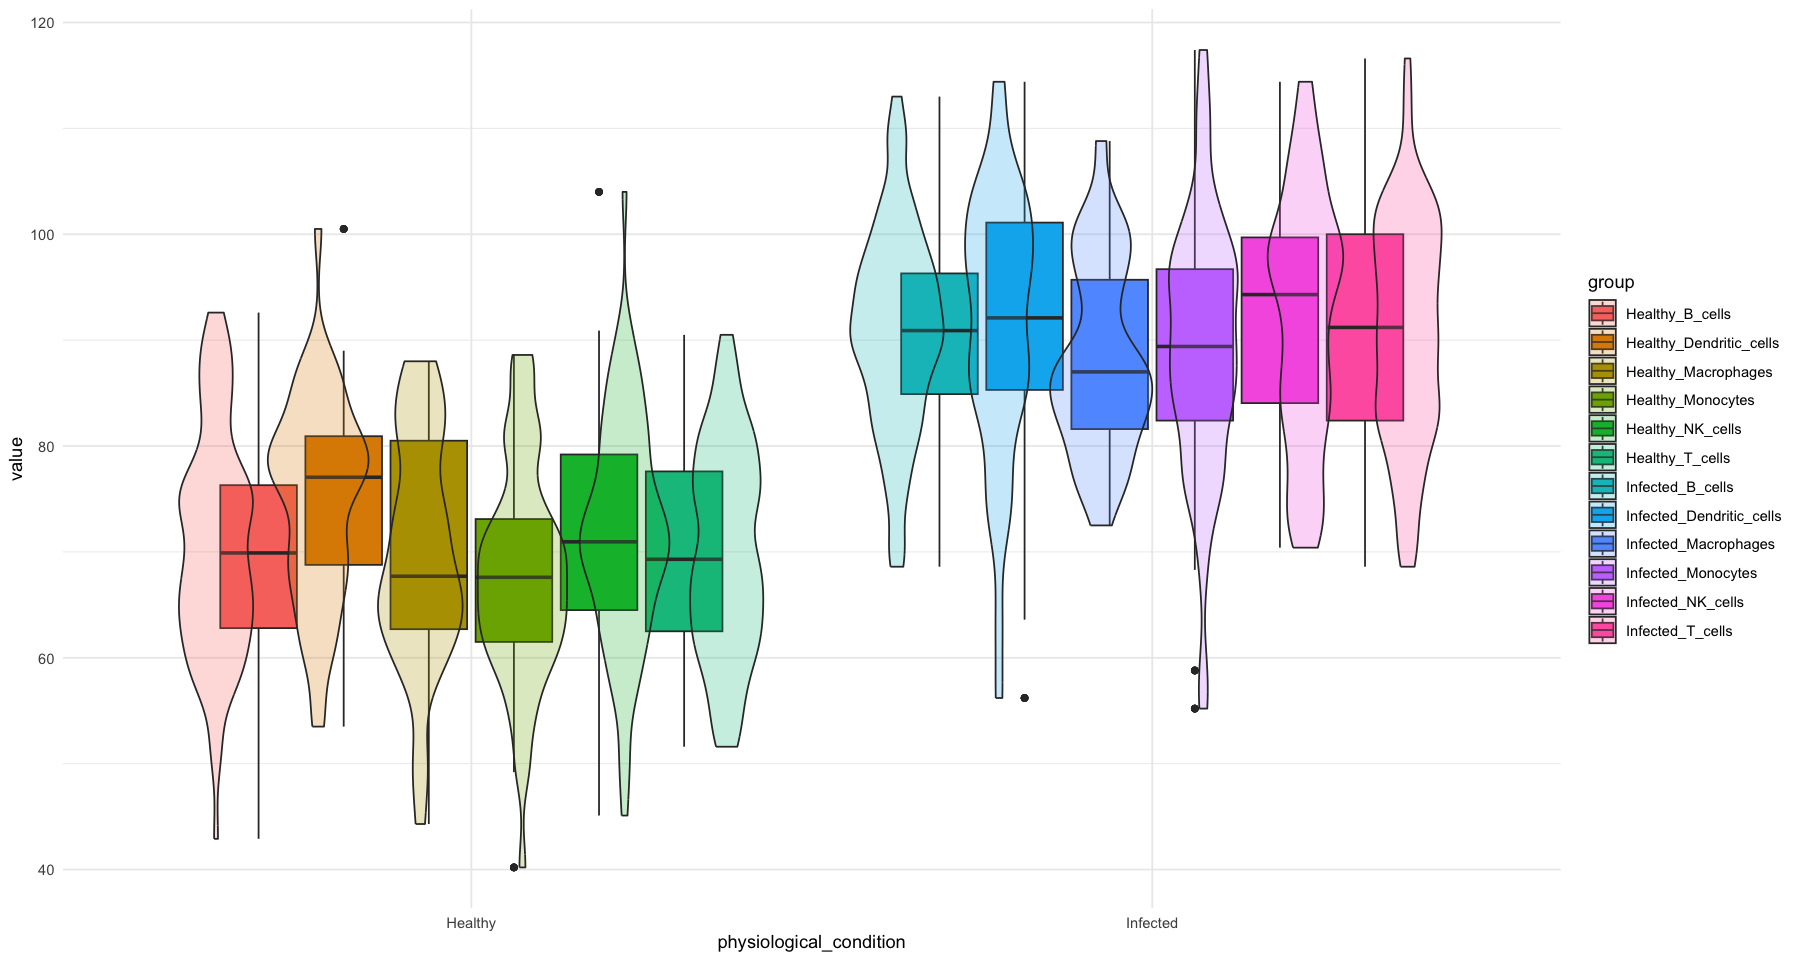

In [104]:
h_inf_resp_long = sharks_super_long %>%
    filter(physiological_condition %in% c("Healthy","Infected")) %>%
    filter(variable == "response_to_infection")
    
ggplot(h_inf_resp_long, aes(x=physiological_condition, y=value, fill=group)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal()

### [WIP] Immune Receptor Diversity Profiles

In [105]:
h_inf_div = h_inf_immune[h_inf_immune$variable=="response_to_infection", ]
h_inf_div %>%
    group_by(group) %>%
    summarise(p_value = shapiro.test(value)$p.value)

group,p_value
<chr>,<dbl>
Healthy_B_cells,0.38110251
Healthy_Dendritic_cells,0.71980928
Healthy_Macrophages,0.31956204
Healthy_Monocytes,0.64377979
Healthy_NK_cells,0.93212107
Healthy_T_cells,0.17071049
Infected_B_cells,0.92177458
Infected_Dendritic_cells,0.30026314
Infected_Macrophages,0.26508931


In [106]:
leveneTest(data=healthy_infected, immune_receptor_diversity ~ group)

Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,11,4.164911,5.538573e-06
,708,NA,NA


In [107]:
h_inf_div_kw = kruskal.test(data=healthy_infected, immune_receptor_diversity ~ group)
print(h_inf_div_kw)


	Kruskal-Wallis rank sum test

data:  immune_receptor_diversity by group
Kruskal-Wallis chi-squared = 288.27, df = 11, p-value < 2.2e-16



In [108]:
h_inf_div_dunn = (dunnTest(data=h_inf_div, value ~ group, method="holm")$res)

div_diff_res = h_inf_inflam_dunn[h_inf_inflam_dunn$P.adj < 0.05, ]

div_pair_lst = unique(div_diff_res$Comparison)

Warning message:
"group was coerced to a factor."


In [109]:
pair_presence_matrix(div_pair_lst,TRUE)

,Healthy_Monocytes,Healthy_Dendritic_cells,Healthy_T_cells,Healthy_NK_cells,Healthy_B_cells,Healthy_Macrophages,Infected_Monocytes,Infected_Dendritic_cells,Infected_T_cells,Infected_NK_cells,Infected_B_cells,Infected_Macrophages
Healthy_Monocytes,|,.,.,O,.,.,.,.,.,O,.,.
Healthy_Dendritic_cells,.,|,.,O,.,.,.,.,.,O,.,.
Healthy_T_cells,.,.,|,O,.,.,.,.,.,O,.,.
Healthy_NK_cells,O,O,O,|,O,O,O,O,O,.,O,O
Healthy_B_cells,.,.,.,O,|,.,.,.,.,O,.,.
Healthy_Macrophages,.,.,.,O,.,|,.,.,.,O,.,.
Infected_Monocytes,.,.,.,O,.,.,|,.,.,O,.,.
Infected_Dendritic_cells,.,.,.,O,.,.,.,|,.,O,.,.
Infected_T_cells,.,.,.,O,.,.,.,.,|,O,.,.
Infected_NK_cells,O,O,O,.,O,O,O,O,O,|,O,O


In [110]:
check_NK_pair(div_pair_lst)

[1] "20 pairs where p adj < 0.05"
[1] "0 pairs neither cell type is not an NK cell."
[1] "20 pairs where at least one cell type is an NK cell."
[1] "All pairs where p adj < 0.05 have at least one cell type that is an NK cell."


In [111]:
NK_partner_matrix(div_pair_lst)

,Monocytes,Dendritic_cells,T_cells,NK_cells,B_cells,Macrophages
H - H,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
H - I,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
I - H,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
I - I,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE


## 2. Immunity Gene Reactions in Injury or Infection

How do the immune genes react in case of injury or infection?

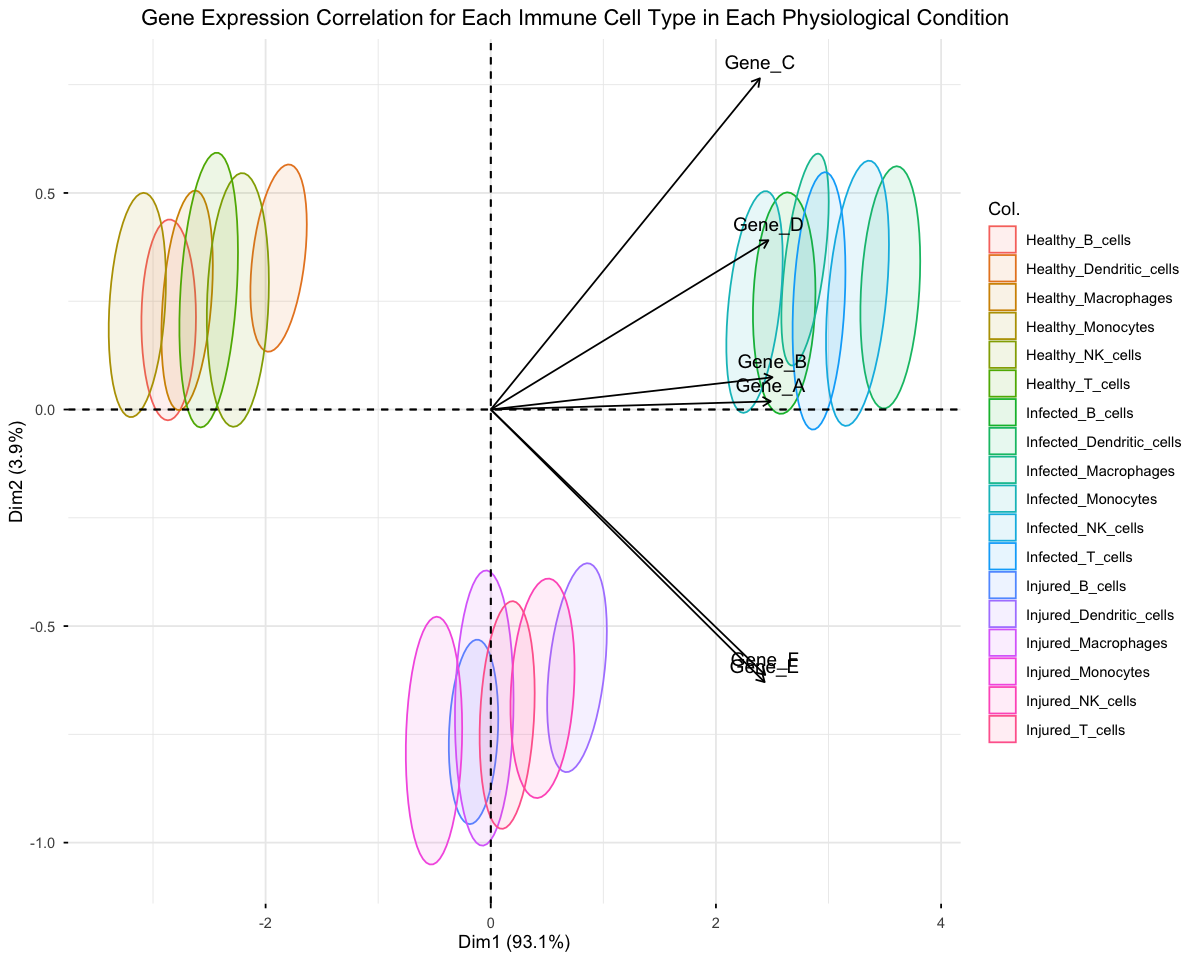

In [112]:
# healthy, injured, and infected population
h_inj_inf = sharks %>% filter(physiological_condition %in% c("Healthy", "Injured", "Infected"))

# PCA on the gene expression levels
h_inj_inf_pca = PCA(h_inj_inf[c("Gene_A","Gene_B","Gene_C","Gene_D","Gene_E","Gene_F")], scale.unit=TRUE, graph=FALSE)

# customize graph size
options(repr.plot.width=10, repr.plot.height=8)

# MDS cloud plot with correlation circle
fviz_pca_biplot(h_inj_inf_pca, geom.ind="None", col.ind=h_inj_inf$group, col.var="black", addEllipses=TRUE, ellipse.level=0.5, title="Gene Expression Correlation for Each Immune Cell Type in Each Physiological Condition") +
    theme(plot.title=element_text(hjust=3))

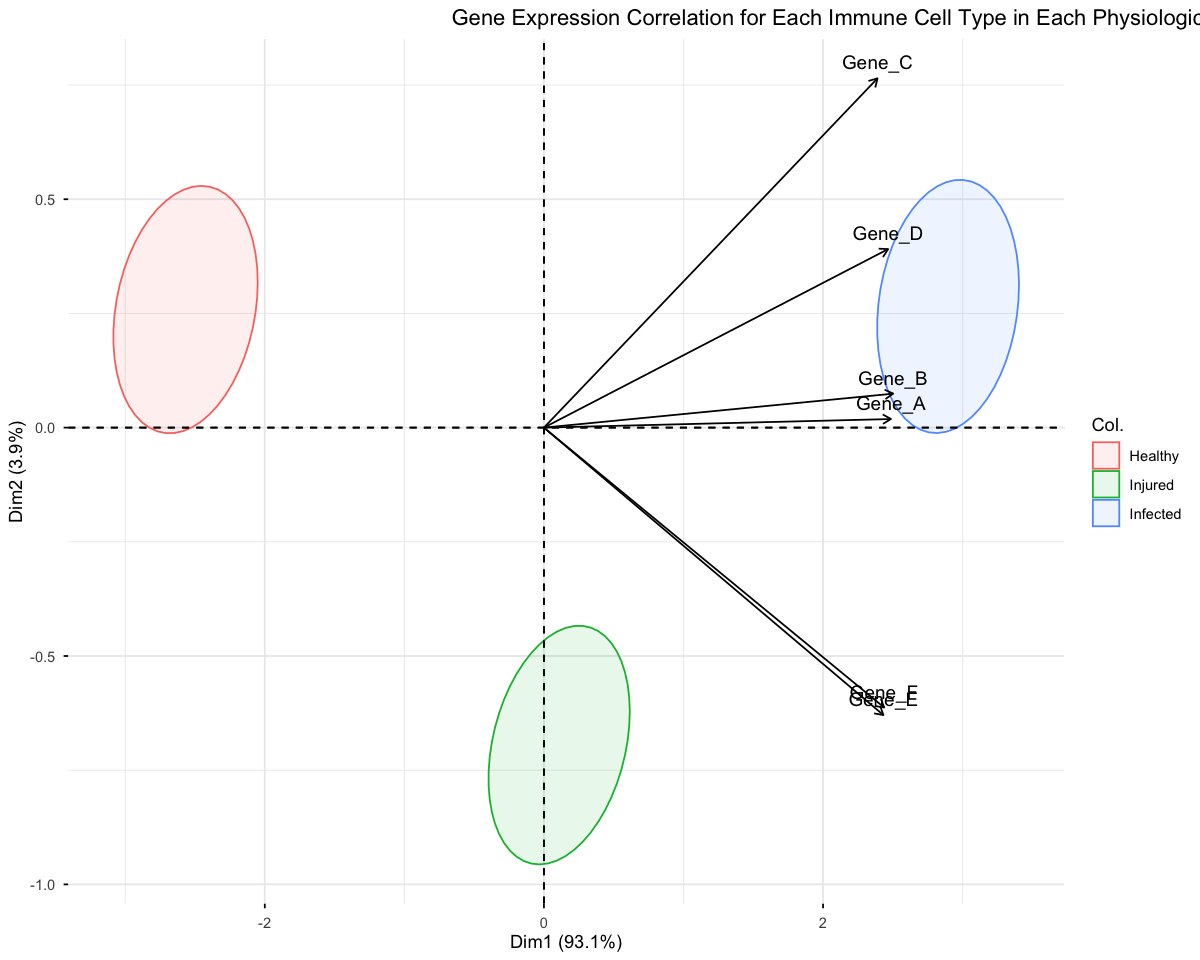

In [182]:
fviz_pca_biplot(h_inj_inf_pca, geom.ind="None", col.ind=h_inj_inf$physiological_condition, col.var="black", addEllipses=TRUE, ellipse.level=0.5, title="Gene Expression Correlation for Each Immune Cell Type in Each Physiological Condition") +
    theme(plot.title=element_text(hjust=3))

***
try PCAs on healthy-infected / healthy-injured
***

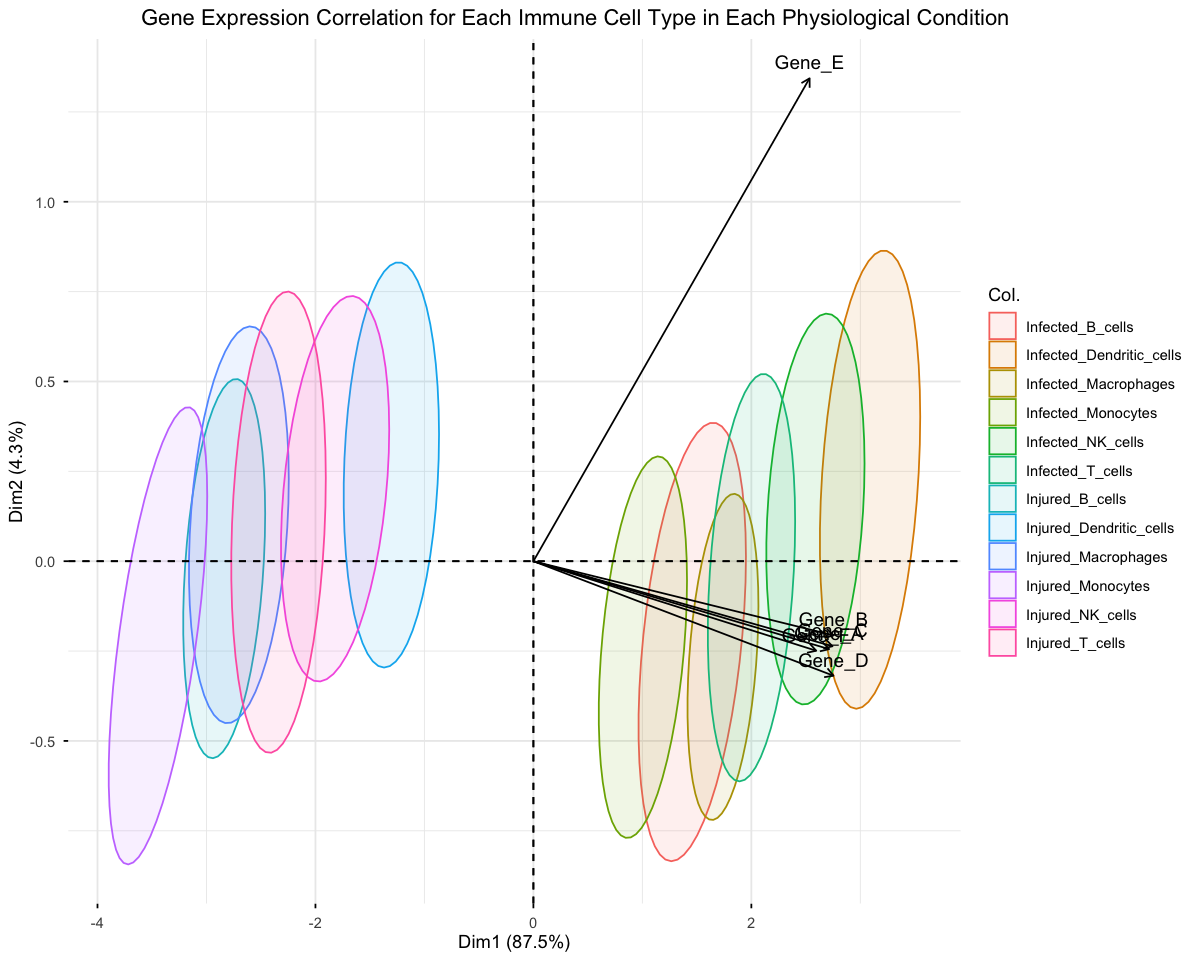

In [113]:
inj_inf = sharks %>% filter(physiological_condition %in% c("Injured", "Infected"))

# PCA on the gene expression levels
inj_inf_pca = PCA(inj_inf[c("Gene_A","Gene_B","Gene_C","Gene_D","Gene_E","Gene_F")], scale.unit=TRUE, graph=FALSE)

# customize graph size
options(repr.plot.width=10, repr.plot.height=8)

# MDS cloud plot with correlation circle
fviz_pca_biplot(inj_inf_pca, geom.ind="None", col.ind=inj_inf$group, col.var="black", addEllipses=TRUE, ellipse.level=0.5, title="Gene Expression Correlation for Each Immune Cell Type in Each Physiological Condition") +
    theme(plot.title=element_text(hjust=3))

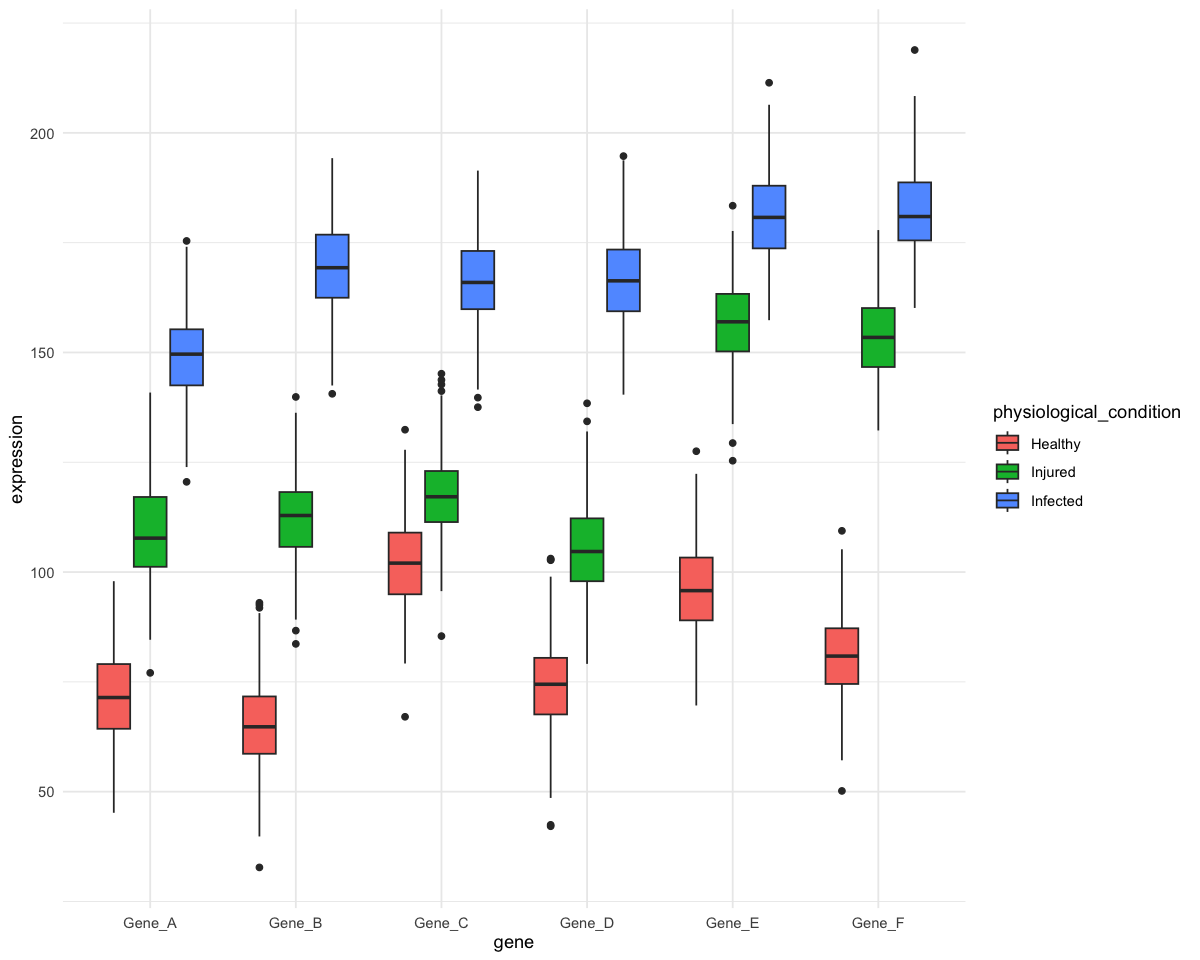

In [167]:
hjf_genes = shark_genes %>% 
    select(physiological_condition, gene, expression) %>%
    filter(physiological_condition %in% c("Healthy", "Injured", "Infected"))
hjf_genes$group = paste(hjf_genes$physiological_condition, hjf_genes$gene, sep="-")

ggplot(hjf_genes, aes(x=gene,y=expression,fill=physiological_condition)) +
    geom_boxplot() +
    theme_minimal()

In [168]:
head(hjf_genes)

physiological_condition,gene,expression,group
<fct>,<chr>,<dbl>,<chr>
Infected,Gene_A,144.7960,Infected-Gene_A
Infected,Gene_B,171.1046,Infected-Gene_B
Infected,Gene_C,162.1400,Infected-Gene_C
Infected,Gene_D,158.4442,Infected-Gene_D
Infected,Gene_E,171.3381,Infected-Gene_E
Infected,Gene_F,168.4784,Infected-Gene_F


In [170]:
hjf_genes %>% 
    group_by(group) %>%
    summarise(p_value = shapiro.test(expression)$p.value)

# Gene F not normal

group,p_value
<chr>,<dbl>
Healthy-Gene_A,0.25276498
Healthy-Gene_B,0.33330323
Healthy-Gene_C,0.93459598
Healthy-Gene_D,0.67167228
Healthy-Gene_E,0.34124269
Healthy-Gene_F,0.84475145
Infected-Gene_A,0.52911997
Infected-Gene_B,0.34204193
Infected-Gene_C,0.89057793


### permanova stint

In [179]:
hjf = sharks %>% filter(physiological_condition %in% c("Healthy","Injured","Infected"))

gene_matrix = hjf %>%
    select(Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F)

group_labels = hjf$physiological_condition

set.seed(358)
permanova_res = adonis2(gene_matrix ~ group_labels, method="euclidean", permutations=999)
permanova_res

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,2,8681252.8,0.93577966,7198.266,0.001
Residual,988,595773.8,0.06422034,NA,NA
Total,990,9277026.6,1.00000000,NA,NA


Pr(>F) < 0.05 : profiles differ significantly between conditions

R^2 = 0.25 : 25% of the variation is explained by the physiological condition

In [180]:
# Function for pairwise PERMANOVA
pairwise_permanova <- function(data, grouping, method="euclidean", permutations=999) {
  groups <- unique(grouping)
  results <- list()
  
  for (i in 1:(length(groups)-1)) {
    for (j in (i+1):length(groups)) {
      subset_idx <- grouping %in% c(groups[i], groups[j])
      subset_data <- data[subset_idx, ]
      subset_group <- grouping[subset_idx]
      
      res <- adonis2(subset_data ~ subset_group, method=method, permutations=permutations)
      results[[paste(groups[i], "vs", groups[j])]] <- res
    }
  }
  return(results)
}

# Run pairwise PERMANOVA
pairwise_res <- pairwise_permanova(gene_matrix, group_labels)
pairwise_res

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,1851973,0.8376712,3106.523,0.001
Residual,602,358886,0.1623288,NA,NA
Total,603,2210859,1.0000000,NA,NA
,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,8392408.2,0.95089842,13904.75,0.001
Residual,718,433359.1,0.04910158,NA,NA
Total,719,8825767.3,1.00000000,NA,NA
,Df,SumOfSqs,R2,F,Pr(>F)


### PC2 contribution

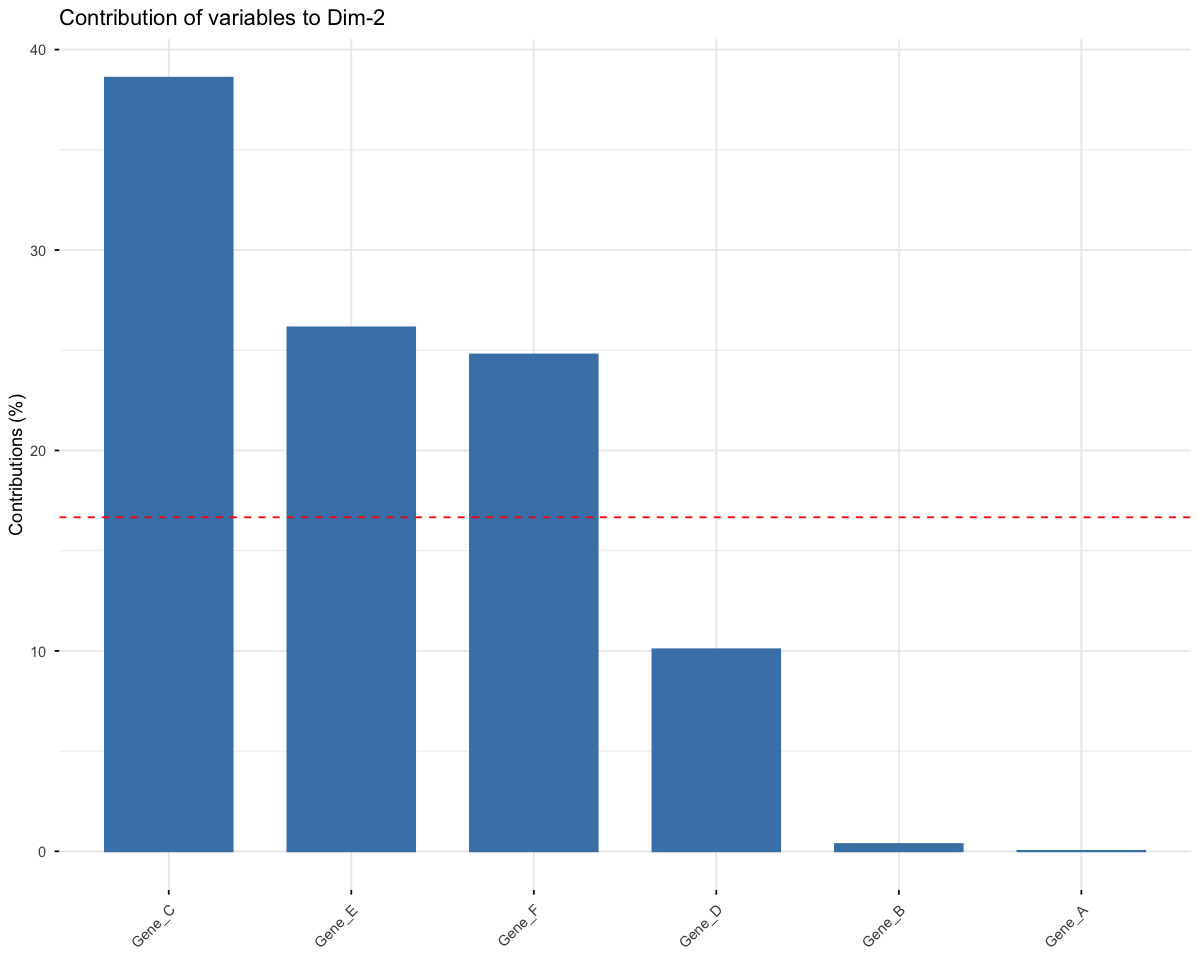

In [188]:
# Show contribution of genes to PCs
fviz_contrib(h_inj_inf_pca, choice = "var", axes = 2)

In [202]:
hjf_pca_vars <- get_pca_var(h_inj_inf_pca)
hjf_contrib <- data.frame(
  gene = rownames(hjf_pca_vars$contrib),
  contrib = hjf_pca_vars$contrib[, 2]  # dimension 2
)
hjf_contrib

,gene,contrib
,<chr>,<dbl>
Gene_A,Gene_A,0.02362708
Gene_B,Gene_B,0.36608509
Gene_C,Gene_C,38.59718335
Gene_D,Gene_D,10.08238444
Gene_E,Gene_E,26.14092502
Gene_F,Gene_F,24.78979501


In [203]:
top_genes = hjf_contrib$gene[hjf_contrib$contrib > 16]
top_genes = as.character(top_genes)

In [210]:
hjf_CEF = hjf_genes %>% filter(gene %in% c("Gene_C","Gene_E","Gene_F"))

In [211]:
hjf_CEF %>%
    group_by(gene, physiological_condition) %>%
    summarise(shapiro_p = shapiro.test(expression)$p.value)

`summarise()` has grouped output by 'gene'. You can override using the
`.groups` argument.


gene,physiological_condition,shapiro_p
<chr>,<fct>,<dbl>
Gene_C,Healthy,0.93459598
Gene_C,Injured,0.11543153
Gene_C,Infected,0.89057793
Gene_E,Healthy,0.34124269
Gene_E,Injured,0.91053059
Gene_E,Infected,0.42413152
Gene_F,Healthy,0.84475145
Gene_F,Injured,0.05008131
Gene_F,Infected,0.02091058


In [214]:
for (g in top_genes) {
    cat("\nGene:",g,"\n")
    gene_data = hjf_CEF %>% filter(gene == g)
    print(kruskal.test(data = gene_data, expression ~ physiological_condition))
    print(dunnTest(data = gene_data, expression ~ physiological_condition, method="holm"))
}


Gene: Gene_C 

	Kruskal-Wallis rank sum test

data:  expression by physiological_condition
Kruskal-Wallis chi-squared = 775.8, df = 2, p-value < 2.2e-16



Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Holm method.




          Comparison         Z       P.unadj         P.adj
1 Healthy - Infected -27.80428 3.850030e-170 1.155009e-169
2  Healthy - Injured -10.65059  1.732544e-26  1.732544e-26
3 Infected - Injured  15.09140  1.844801e-51  3.689602e-51

Gene: Gene_E 

	Kruskal-Wallis rank sum test

data:  expression by physiological_condition
Kruskal-Wallis chi-squared = 847.87, df = 2, p-value < 2.2e-16



Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Holm method.




          Comparison         Z       P.unadj         P.adj
1 Healthy - Infected -28.99142 8.439642e-185 2.531893e-184
2  Healthy - Injured -15.09453  1.759308e-51  3.518617e-51
3 Infected - Injured  11.87344  1.626326e-32  1.626326e-32

Gene: Gene_F 

	Kruskal-Wallis rank sum test

data:  expression by physiological_condition
Kruskal-Wallis chi-squared = 860.03, df = 2, p-value < 2.2e-16



Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Holm method.




          Comparison         Z       P.unadj         P.adj
1 Healthy - Infected -29.23775 6.427706e-188 1.928312e-187
2  Healthy - Injured -14.80932  1.275188e-49  2.550376e-49
3 Infected - Injured  12.37463  3.585247e-35  3.585247e-35


### attempt at difference in means (Student's T-test)?

In [115]:
gene_means = h_inj_inf_genes %>%
    group_by(physiological_condition, gene) %>%
    summarise(mean_expression = mean(expression, na.rm=TRUE))

`summarise()` has grouped output by 'physiological_condition'. You can override
using the `.groups` argument.


In [150]:
gene_means

physiological_condition,gene,mean_expression
<fct>,<chr>,<dbl>
Healthy,Gene_A,71.63468
Healthy,Gene_B,65.07333
Healthy,Gene_C,102.17526
Healthy,Gene_D,74.30687
Healthy,Gene_E,95.88074
Healthy,Gene_F,81.04480
Injured,Gene_A,108.54780
Injured,Gene_B,112.06262
Injured,Gene_C,117.49971


In [153]:
means_A = gene_means %>% filter(gene == "Gene_A")
means_B = gene_means %>% filter(gene == "Gene_B")
means_C = gene_means %>% filter(gene == "Gene_C")
means_D = gene_means %>% filter(gene == "Gene_D")
means_E = gene_means %>% filter(gene == "Gene_E")
means_F = gene_means %>% filter(gene == "Gene_F")

In [155]:
means_A

physiological_condition,gene,mean_expression
<fct>,<chr>,<dbl>
Healthy,Gene_A,71.63468
Injured,Gene_A,108.54780
Infected,Gene_A,149.23501


In [156]:
t.test(mean_expression ~ physiological_condition, means_A)

ERROR: Error in t.test.formula(mean_expression ~ physiological_condition, means_A): grouping factor must have exactly 2 levels


In [149]:
hjf_genes = h_inj_inf_genes %>%
    select(physiological_condition, gene, expression)
hjf_genes$group = paste(hjf_genes$physiological_condition,hjf_genes$gene, sep="-")

hjf_genes

physiological_condition,gene,expression,group
<fct>,<chr>,<dbl>,<chr>
Infected,Gene_A,144.79600,Infected-Gene_A
Infected,Gene_B,171.10457,Infected-Gene_B
Infected,Gene_C,162.13997,Infected-Gene_C
Infected,Gene_D,158.44421,Infected-Gene_D
Infected,Gene_E,171.33809,Infected-Gene_E
Infected,Gene_F,168.47842,Infected-Gene_F
Injured,Gene_A,108.08071,Injured-Gene_A
Injured,Gene_B,127.09696,Injured-Gene_B
Injured,Gene_C,130.13870,Injured-Gene_C


In [117]:
geneGroup_mean = function(cond) {
    return(mean(hjf_genes[hjf_genes$group==toString(cond), ]$expression))
}

In [118]:
diff_vect = list()
hjf_groups = as.list(unique(hjf_genes$group))
for (a in hjf_groups) {
    for (b in hjf_groups) {
        mean_a = geneGroup_mean(a)
        mean_b = geneGroup_mean(b)
        diff_vect = c(diff_vect, abs(mean_a - mean_b))
    }
}

In [119]:
cond_gene = as.list(unique(hjf_genes$group))
mean_diff_matrix = matrix(
    diff_vect,
    nrow = length(cond_gene),
    ncol = length(cond_gene),
    byrow = TRUE
)
rownames(mean_diff_matrix) = cond_gene
colnames(mean_diff_matrix) = cond_gene

mean_diff_matrix

Infected-Gene_A Infected-Gene_B Infected-Gene_C Infected-Gene_D
Infected-Gene_A 0               20.24927        16.79055        17.01781       
Infected-Gene_B 20.24927        0               3.458726        3.231462       
Infected-Gene_C 16.79055        3.458726        0               0.2272647      
Infected-Gene_D 17.01781        3.231462        0.2272647       0              
Infected-Gene_E 31.60239        11.35311        14.81184        14.58458       
Infected-Gene_F 32.88515        12.63588        16.09461        15.86734       
Injured-Gene_A  40.68721        60.93648        57.47776        57.70502       
Injured-Gene_B  37.17239        57.42166        53.96293        54.1902        
Injured-Gene_C  31.73531        51.98458        48.52585        48.75312       
Injured-Gene_D  43.77611        64.02538        60.56665        60.79392       
Injured-Gene_E  7.459782        12.78949        9.330764        9.558029       
Injured-Gene_F  4.440318        15.80895        12.35023        12.57749       
Healthy-Gene_A  77.60033        97.8496         94.39087        94.61814       
Healthy-Gene_B  84.16168        104.411         100.9522        101.1795       
Healthy-Gene_C  47.05975        67.30902        63.85029        64.07756       
Healthy-Gene_D  74.92814        95.17741        91.71868        91.94595       
Healthy-Gene_E  53.35427        73.60354        70.14482        70.37208       
Healthy-Gene_F  68.19021        88.43948        84.98075        85.20802       
                Infected-Gene_E Infected-Gene_F Injured-Gene_A Injured-Gene_B
Infected-Gene_A 31.60239        32.88515        40.68721       37.17239      
Infected-Gene_B 11.35311        12.63588        60.93648       57.42166      
Infected-Gene_C 14.81184        16.09461        57.47776       53.96293      
Infected-Gene_D 14.58458        15.86734        57.70502       54.1902       
Infected-Gene_E 0               1.282766        72.2896        68.77477      
Infected-Gene_F 1.282766        0               73.57236       70.05754      
Injured-Gene_A  72.2896         73.57236        0              3.514827      
Injured-Gene_B  68.77477        70.05754        3.514827       0             
Injured-Gene_C  63.33769        64.62046        8.951908       5.437081      
Injured-Gene_D  75.37849        76.66126        3.088893       6.603721      
Injured-Gene_E  24.1426         25.42537        48.14699       44.63217      
Injured-Gene_F  27.16207        28.44483        45.12753       41.6127       
Healthy-Gene_A  109.2027        110.4855        36.91311       40.42794      
Healthy-Gene_B  115.7641        117.0468        43.47447       46.98929      
Healthy-Gene_C  78.66213        79.9449         6.372536       9.887364      
Healthy-Gene_D  106.5305        107.8133        34.24092       37.75575      
Healthy-Gene_E  84.95666        86.23942        12.66706       16.18189      
Healthy-Gene_F  99.79259        101.0754        27.503         31.01782      
                Injured-Gene_C Injured-Gene_D Injured-Gene_E Injured-Gene_F
Infected-Gene_A 31.73531       43.77611       7.459782       4.440318      
Infected-Gene_B 51.98458       64.02538       12.78949       15.80895      
Infected-Gene_C 48.52585       60.56665       9.330764       12.35023      
Infected-Gene_D 48.75312       60.79392       9.558029       12.57749      
Infected-Gene_E 63.33769       75.37849       24.1426        27.16207      
Infected-Gene_F 64.62046       76.66126       25.42537       28.44483      
Injured-Gene_A  8.951908       3.088893       48.14699       45.12753      
Injured-Gene_B  5.437081       6.603721       44.63217       41.6127       
Injured-Gene_C  0              12.0408        39.19509       36.17562      
Injured-Gene_D  12.0408        0              51.23589       48.21642      
Injured-Gene_E  39.19509       51.23589       0              3.019463      
Injured-Gene_F  36.17562       48.21642       3.019463       0             
Healthy-Gene_A  45.86502  

In [134]:
cond_diff_vect = list()
genes = as.list(unique(shark_genes$gene))

for (gene in genes) {
    for (cond in c("Injured","Infected")) {
        elemH = paste("Healthy",gene,sep="-")
        elemI = paste(cond,gene,sep="-")
        cond_diff_vect = c(cond_diff_vect, mean_diff_matrix[elemH, elemI])
    }
    elemH = paste("Injured",gene,sep="-")
    elemI = paste("Infected",gene,sep="-")
    cond_diff_vect = c(cond_diff_vect, mean_diff_matrix[elemH, elemI])
}

In [140]:
hjf_conds = c("Healthy_Injured", "Healthy_Infected", "Injured_Infected")
perCond_mean_diff_matrix = matrix(
    cond_diff_vect,
    nrow = length(genes),
    ncol = length(hjf_conds),
    byrow = TRUE
)
rownames(perCond_mean_diff_matrix) = genes
colnames(perCond_mean_diff_matrix) = hjf_conds

perCond_mean_diff_matrix

Healthy_Injured Healthy_Infected Injured_Infected
Gene_A 36.91311        77.60033         40.68721        
Gene_B 46.98929        104.411          57.42166        
Gene_C 15.32444        63.85029         48.52585        
Gene_D 31.15203        91.94595         60.79392        
Gene_E 60.81405        84.95666         24.1426         
Gene_F 72.63053        101.0754         28.44483

### previous

In [123]:
h_inj_inf_genes %>%
    group_by(physiological_condition, gene) %>%
    summarise(p_value = shapiro.test(expression)$p.value)

`summarise()` has grouped output by 'physiological_condition'. You can override
using the `.groups` argument.


physiological_condition,gene,p_value
<fct>,<chr>,<dbl>
Healthy,Gene_A,0.25276498
Healthy,Gene_B,0.33330323
Healthy,Gene_C,0.93459598
Healthy,Gene_D,0.67167228
Healthy,Gene_E,0.34124269
Healthy,Gene_F,0.84475145
Injured,Gene_A,0.13715658
Injured,Gene_B,0.78263937
Injured,Gene_C,0.11543153


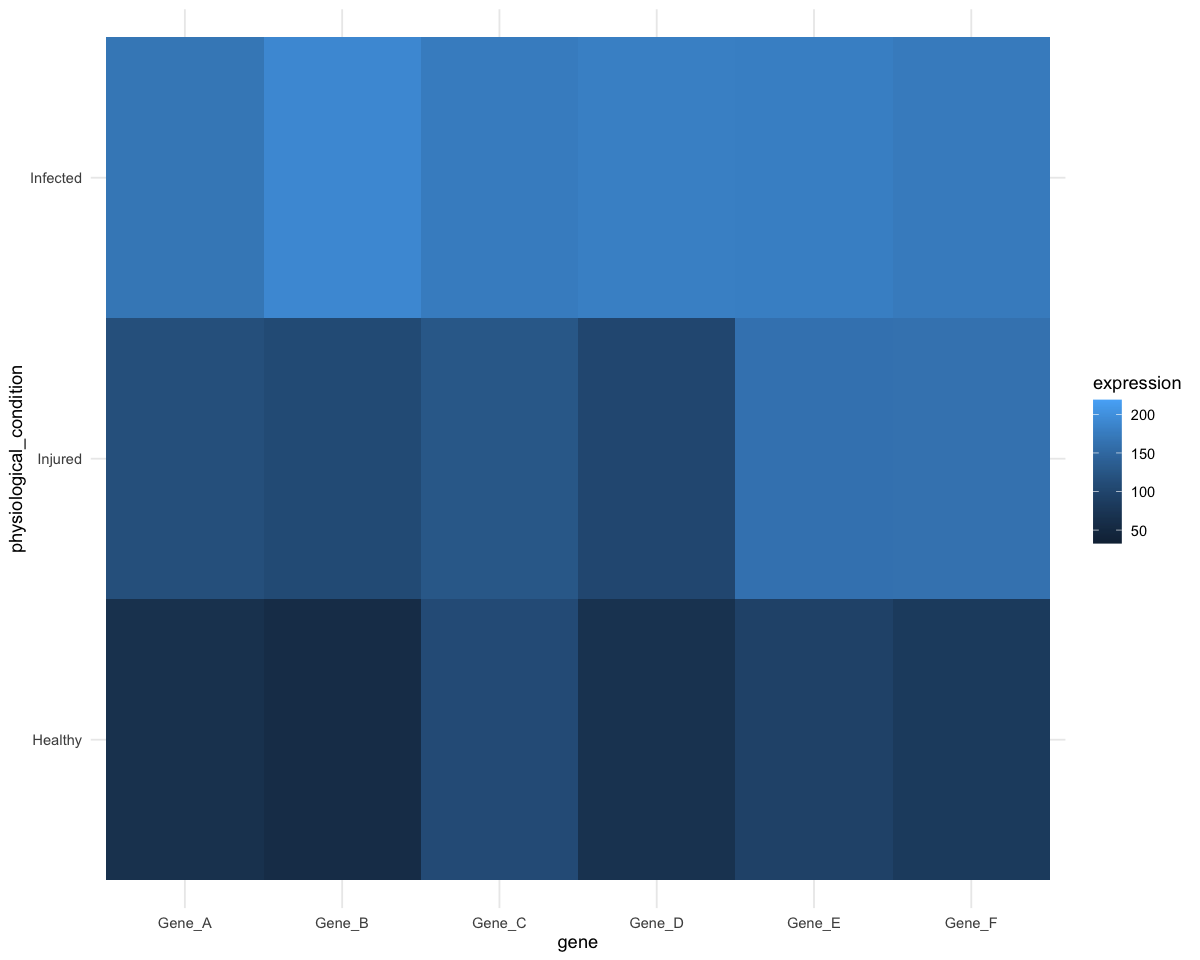

In [124]:
ggplot(h_inj_inf_genes, aes(x=gene,y=physiological_condition,fill=expression)) +
    geom_tile() +
    theme_minimal()

In [125]:
h_inj_inf_genes_anova = aov(data=h_inj_inf_genes, expression ~ gene)
summary(h_inj_inf_genes_anova)

              Df  Sum Sq Mean Sq F value Pr(>F)    
gene           5  898910  179782   115.1 <2e-16 ***
Residuals   5940 9277027    1562                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [126]:
h_inf_inj_sansF = h_inj_inf_genes %>% filter(gene != "Gene_F")

h_inf_inj_F = h_inj_inf_genes %>% filter(gene == "Gene_F")

In [127]:
# without Gene F
h_inf_inj_sansF_anova = aov(data=h_inf_inj_sansF, expression ~ gene)
summary(h_inf_inj_sansF_anova)

              Df  Sum Sq Mean Sq F value Pr(>F)    
gene           4  732683  183171   125.6 <2e-16 ***
Residuals   4950 7218706    1458                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [128]:
# with Gene F
summary(aov(data=h_inj_inf_genes, expression ~ gene))

              Df  Sum Sq Mean Sq F value Pr(>F)    
gene           5  898910  179782   115.1 <2e-16 ***
Residuals   5940 9277027    1562                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

# Report Outline

## Presentation of the Dataset

1345 observations accounting for 17 variables (not counting the observation ID)

Qualitative Variables 
| variable | values |
| :-: | :-: |
| physiological condition | Healthy, Stressed, Injured, Infected, Recovering |
| immune cell type | Monocytes, Dendritic Cells, T Cells, NK Cells, B Cells, Macrophages |
| habitat location | Indian, Southern, Artic, Pacific, Atlantic |

Quantitative Variables
| variable | min | max | average | standard deviation | variance |
| :-: | :-: | :-: | :-: | :-: | :-: |
| gene expression (6x : A, B, C, D, E, F) | 32.75 | 218.8 | 117.32 | 37.47 | 1402.98 |
| regeneration capacity | 83.2 | 151.9 | 119.0 | 12.55 | 157.48 |
| age (years) | 5.00 | 60.00 | 32.91 | 16.15 | 260.96 |
| immune receptor diversity | 44.9 | 102.7 | 73.4 | 12.79 | 163.60 |
| response to infection | 40.20 | 118.30 | 77.85 | 13.09 | 171.29 |
| inflammation level | 12.80 | 122.90 | 35.97 | 24.35 | 592.81 |
| weight (kg) | 276.2 | 679.7 | 498.1 | 62.05 | 3850.53 |
| resilience score | 98.9 | 174.1 | 128.6 | 13.45 | 180.97 |
| reproduction rate | 6.90 | 25.00 | 14.86 | 5.04 | 25.42 |

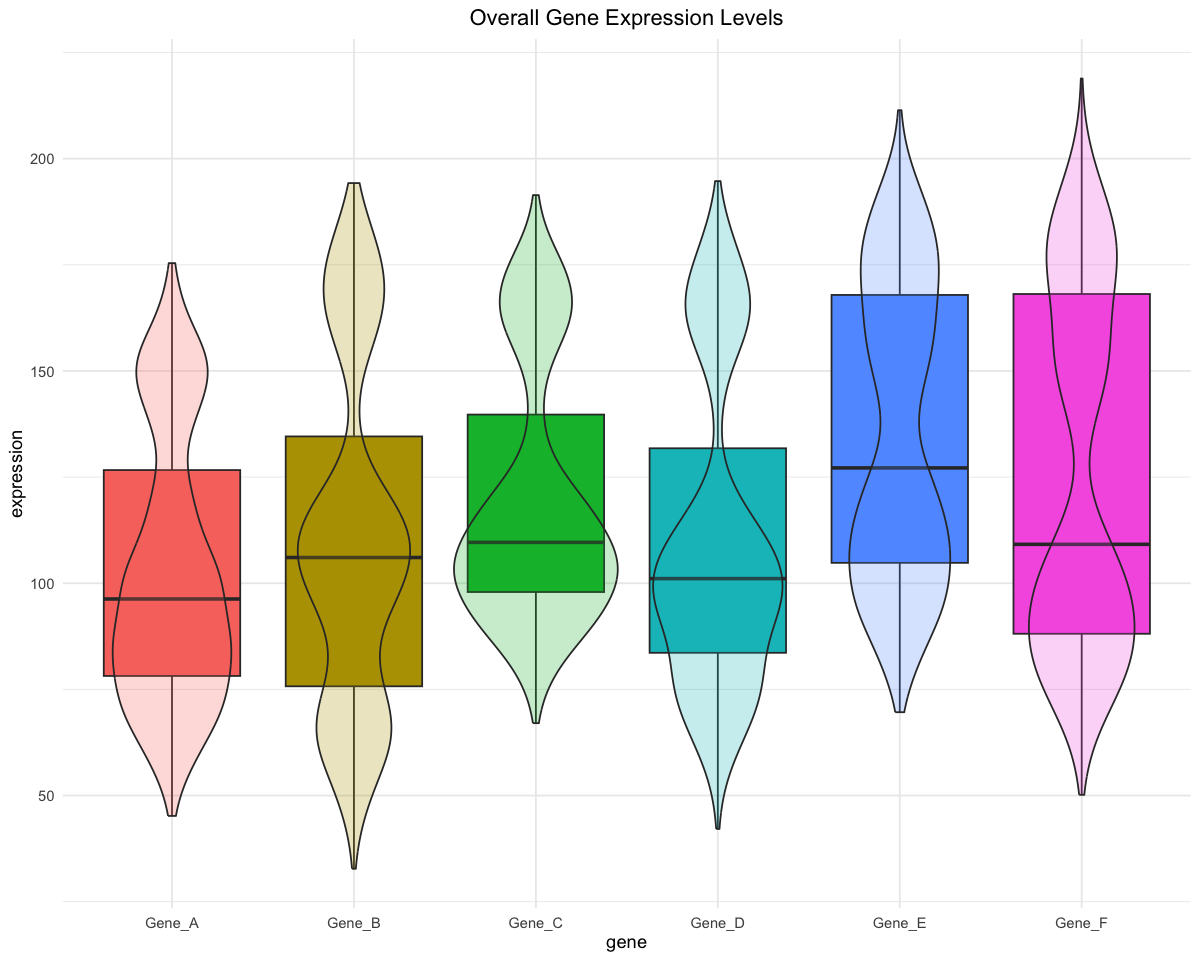

In [129]:
# visualizing expression levels for each gene
ggplot(shark_genes, aes(x=gene,y=expression,fill=gene)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal() +
    theme(
        plot.title=element_text(hjust=0.5),
        legend.position="None"
    ) +
    ggtitle("Overall Gene Expression Levels")

In [130]:
# code obtain information on the dataset
sprintf("%d entries, %d categories (not including )", nrow(sharks), ncol(sharks)-1)
names(sharks)
unique(sharks$physiological_condition)
unique(sharks$immune_cell_type)
unique(sharks$habitat_location)
summary(sharks)

[1] "1345 entries, 18 categories (not including )"

[1] "ID"                        "physiological_condition"  
 [3] "immune_cell_type"          "Gene_A"                   
 [5] "Gene_B"                    "Gene_C"                   
 [7] "Gene_D"                    "Gene_E"                   
 [9] "Gene_F"                    "regeneration_capacity"    
[11] "age_years"                 "immune_receptor_diversity"
[13] "response_to_infection"     "inflammation_level"       
[15] "weight_kg"                 "habitat_location"         
[17] "resilience_score"          "reproduction_rate"        
[19] "group"

[1] Infected   Injured    Healthy    Stressed   Recovering
Levels: Healthy Stressed Injured Infected Recovering

[1] "Monocytes"       "Dendritic_cells" "T_cells"         "NK_cells"       
[5] "B_cells"         "Macrophages"

[1] "Indian"   "Southern" "Arctic"   "Pacific"  "Atlantic"

       ID       physiological_condition immune_cell_type       Gene_A      
 Min.   :   1   Healthy   :387          Length:1345        Min.   : 45.20  
 1st Qu.: 337   Stressed  :201          Class :character   1st Qu.: 78.16  
 Median : 673   Injured   :271          Mode  :character   Median : 96.29  
 Mean   : 673   Infected  :333                             Mean   :102.87  
 3rd Qu.:1009   Recovering:153                             3rd Qu.:126.66  
 Max.   :1345                                              Max.   :175.39  
     Gene_B           Gene_C           Gene_D           Gene_E      
 Min.   : 32.75   Min.   : 67.05   Min.   : 42.13   Min.   : 69.62  
 1st Qu.: 75.73   1st Qu.: 97.93   1st Qu.: 83.62   1st Qu.:104.80  
 Median :106.06   Median :109.63   Median :101.09   Median :127.16  
 Mean   :110.53   Mean   :119.42   Mean   :110.17   Mean   :135.18  
 3rd Qu.:134.58   3rd Qu.:139.72   3rd Qu.:131.79   3rd Qu.:167.90  
 Max.   :194.24   Max.   :191.41   Max.   :194.71   Ma

## Scientific Questions

1. Do the immune reponse profiles differ from one immune cell type to another in the infected condition? If so, how so?

2. How do the immune genes react in case of injury or infection?

## Analytical Approaches and Methods Used

### Immune Response Profiles of Different Immune Cell Types in the Infected Condition

### Immune Gene Reactions to Injury and Infection

## Results Obtained

## Conclusions